In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import utils

In [2]:
core_path = "/data/pushkare/Chromatin_modules/genome_annotations/TADs_AB_compartments"
core_cm_path = "/data/pushkare/Chromatin_modules/1.mapped_CMs"
dataset = "test_data"
methods = ["vcmtools", "clomics", "phm"]

vcm_window = "0.5Mb"
pv_threshold = "0.001"
n_peaks = "n_peaks_200"
bg_threshold = "bg_threshold_3"
pp_threshold = 0.8
save_files = True

if not os.path.exists(os.path.join(core_path, "plots")):
    os.makedirs(os.path.join(core_path, "plots"))

### Get tracks and content files for CMs fully in TADs and AB compartments

In [3]:
for method in methods:
    tracks_df, content_df = utils.get_cm_tracks_content(
        core_cm_path,
        method,
        dataset,
        pp_threshold=pp_threshold,
        vcm_window=vcm_window,
        pv_threshold=pv_threshold,
        n_peaks=n_peaks,
        bg_threshold=bg_threshold,
    )
    cms_in_tads = pd.read_csv(
        os.path.join(
            core_path,
            "cm_overlaps",
            method,
            "_".join([dataset, "TADs", "cm_tracks_overlap.bed"]),
        ),
        sep="\t",
        header=None,
    )
    cms_in_abs = pd.read_csv(
        os.path.join(
            core_path,
            "cm_overlaps",
            method,
            "_".join([dataset, "AB", "cm_tracks_overlap.bed"]),
        ),
        sep="\t",
        header=None,
    )
    # Get CMs fully in TADs based on CM length and CM-TAD overlap in bp
    cms_fully_in_tads = cms_in_tads.loc[
        cms_in_tads.iloc[:, -1] == (cms_in_tads.iloc[:, 2] - cms_in_tads.iloc[:, 1]), :
    ].copy()
    cms_fully_in_tads = cms_fully_in_tads.loc[
        ~cms_fully_in_tads.iloc[:, 3].duplicated(), :
    ].copy()

    # Get CMs fully in A/B compartments based on CM length and CM-AB overlap in bp
    cms_fully_in_abs = cms_in_abs.loc[
        cms_in_abs.iloc[:, -1] == cms_in_abs.iloc[:, 2] - cms_in_abs.iloc[:, 1], :
    ].copy()
    cms_fully_in_abs = cms_fully_in_abs.loc[
        ~cms_fully_in_abs.iloc[:, 3].duplicated(), :
    ].copy()

    cms_fully_in_tads.rename({3: "cm_id"}, axis=1, inplace=True)
    cms_fully_in_abs.rename({3: "cm_id"}, axis=1, inplace=True)

    # Get CM ids for those fully falling into both TADs and A/B compartments
    cms_in_tads_abs = list(
        set(cms_fully_in_abs.loc[:, "cm_id"]).intersection(
            set(cms_fully_in_tads.loc[:, "cm_id"])
        )
    )

    # Subset .tracks and .content files by CM ids
    # fully falling into both TADs and A/B compartments
    cms_fully_in_tads_abs_tracks = cms_fully_in_tads.loc[
        cms_fully_in_tads.loc[:, "cm_id"].isin(cms_in_tads_abs), :
    ].copy()

    cms_fully_in_tads_abs_tracks = cms_fully_in_tads_abs_tracks.merge(
        cms_fully_in_abs.iloc[:, [3, -5, -4, -3, -2, -1]], on="cm_id", how="inner"
    )
    cms_fully_in_tads_abs_content = content_df.loc[
        content_df.iloc[:, 0].isin(cms_in_tads_abs), :
    ].copy()

    # Subset .tracks and .content files by CM ids
    # fully falling into both TADs and A/B compartments
    cms_not_fully_in_tads_abs_tracks = tracks_df[
        ~tracks_df.iloc[:, 3].isin(cms_in_tads_abs)
    ].copy()
    cms_not_fully_in_tads_abs_content = content_df[
        ~content_df.iloc[:, 0].isin(cms_in_tads_abs)
    ].copy()

    assert (
        tracks_df.shape[0]
        == cms_fully_in_tads_abs_tracks.shape[0]
        + cms_not_fully_in_tads_abs_tracks.shape[0]
    )
    assert (
        content_df.shape[0]
        == cms_fully_in_tads_abs_content.shape[0]
        + cms_not_fully_in_tads_abs_content.shape[0]
    )

    output_path = os.path.join(core_path, "cms_fully_in_TADs_ABs", method)
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    cms_fully_in_tads_abs_tracks.to_csv(
        os.path.join(
            output_path,
            "_".join([dataset, method, "cms_fully_in_TADs_and_ABs.tracks.bed"]),
        ),
        sep="\t",
        index=False,
        header=False,
    )

    cms_fully_in_tads_abs_content.to_csv(
        os.path.join(
            output_path,
            "_".join([dataset, method, "cms_fully_in_TADs_and_ABs.content.txt"]),
        ),
        sep="\t",
        index=False,
        header=False,
    )

In [4]:
tads_df_list = []
abs_df_list = []
for method in methods:
    tracks_df, content_df = utils.get_cm_tracks_content(
        core_cm_path,
        method,
        dataset,
        pp_threshold=pp_threshold,
        vcm_window=vcm_window,
        pv_threshold=pv_threshold,
        n_peaks=n_peaks,
        bg_threshold=bg_threshold,
    )
    cms_in_tads = pd.read_csv(
        os.path.join(
            core_path,
            "cm_overlaps",
            method,
            "_".join([dataset, "TADs", "cm_tracks_overlap.bed"]),
        ),
        sep="\t",
        header=None,
    )
    cms_in_abs = pd.read_csv(
        os.path.join(
            core_path,
            "cm_overlaps",
            method,
            "_".join([dataset, "AB", "cm_tracks_overlap.bed"]),
        ),
        sep="\t",
        header=None,
    )
    cms_fully_in_tads = cms_in_tads[
        cms_in_tads.iloc[:, -1] == cms_in_tads.iloc[:, 2] - cms_in_tads.iloc[:, 1]
    ]
    cms_fully_in_abs = cms_in_abs[
        cms_in_abs.iloc[:, -1] == cms_in_abs.iloc[:, 2] - cms_in_abs.iloc[:, 1]
    ]
    cms_fully_in_tads = cms_fully_in_tads[
        ~cms_fully_in_tads.iloc[:, 3].duplicated()
    ].copy()
    cms_fully_in_abs = cms_fully_in_abs[
        ~cms_fully_in_abs.iloc[:, 3].duplicated()
    ].copy()

    n_cms_partially_in_tads = len(
        set(
            cms_in_tads.loc[
                ~cms_in_tads.iloc[:, 3].isin(cms_fully_in_tads.iloc[:, 3]), 3
            ]
        )
    )
    n_cms_partially_in_abs = len(
        set(cms_in_abs.loc[~cms_in_abs.iloc[:, 3].isin(cms_fully_in_abs.iloc[:, 3]), 3])
    )
    cms_fully_in_tads_and_abs = (
        len(set(cms_fully_in_tads.iloc[:, 3]).intersection(cms_fully_in_abs.iloc[:, 3]))
        / tracks_df.shape[0]
    )
    dict_abs_stats = dict(
        cms_fully_in_abs.iloc[:, -2].value_counts() / tracks_df.shape[0]
    )
    dict_abs_stats["partial\noverlap"] = n_cms_partially_in_abs / tracks_df.shape[0]
    dict_abs_stats["no overlap"] = (
        1
        - cms_fully_in_abs.shape[0] / tracks_df.shape[0]
        - n_cms_partially_in_abs / tracks_df.shape[0]
    )
    dict_tads_stats = {
        "TADs": cms_fully_in_tads.shape[0] / tracks_df.shape[0],
        "partial\noverlap": n_cms_partially_in_tads / tracks_df.shape[0],
        "no overlap": 1
        - cms_fully_in_tads.shape[0] / tracks_df.shape[0]
        - n_cms_partially_in_tads / tracks_df.shape[0],
    }
    abs_df_list.append(
        pd.DataFrame.from_dict(dict_abs_stats, orient="index", columns=[method])
    )
    tads_df_list.append(
        pd.DataFrame.from_dict(dict_tads_stats, orient="index", columns=[method])
    )
if any(
    cms_in_abs.iloc[:, -2].apply(
        lambda x: any(
            [ab_type in x for ab_type in ["A1", "A2", "B1", "B2", "B3", "B4"]]
        )
    )
):
    sorted_ab_types = sorted(
        set(cms_in_abs.iloc[:, -2]).intersection(["A1", "A2", "B1", "B2", "B3", "B4"])
    )
else:
    sorted_ab_types = sorted(set(cms_in_abs.iloc[:, -2]).intersection(["A", "B"]))


abs_for_heatmap = pd.concat(abs_df_list, axis=1).loc[
    sorted_ab_types + ["partial\noverlap", "no overlap"], :
]
tads_for_heatmap = pd.concat(tads_df_list, axis=1)

In [5]:
tads_for_heatmap.rename(
    {"vcmtools": "VCMtools", "clomics": "Clomics", "phm": "PHM"}, axis=1, inplace=True
)
abs_for_heatmap.rename(
    {"vcmtools": "VCMtools", "clomics": "Clomics", "phm": "PHM"}, axis=1, inplace=True
)

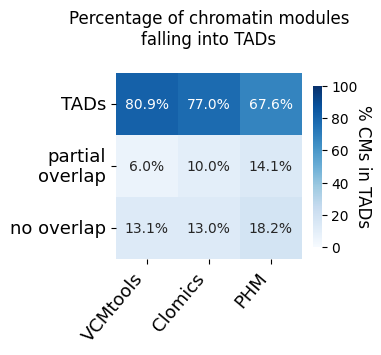

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(3, 7))

hm = sns.heatmap(
    tads_for_heatmap.loc[:, ["VCMtools", "Clomics", "PHM"]] * 100,
    cmap="Blues",
    annot=True,
    cbar=True,
    square=1,
    fmt=".1f",
    vmin=0,
    vmax=100,
    cbar_kws={
        "shrink": 0.3,
    },
)
cbar_ax = fig.axes[-1]
cbar_ax.set_ylabel("% CMs in TADs", rotation=270, labelpad=10, size=12)
for t in hm.texts:
    t.set_text(t.get_text() + "%")

plt.xticks(size=13, rotation=50, ha="right")
plt.yticks(size=13, rotation=0)
plt.title("Percentage of chromatin modules\nfalling into TADs\n")
plt.savefig(
    os.path.join(
        core_path, "plots", "percentage_of_" + dataset + "_CMs_in_TADs_per_method.pdf"
    ),
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

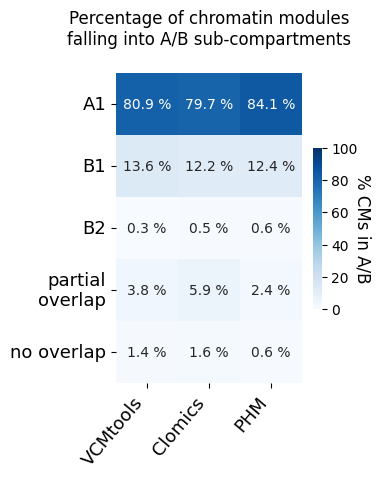

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(3, 7))

hm = sns.heatmap(
    abs_for_heatmap.loc[:, ["VCMtools", "Clomics", "PHM"]] * 100,
    cmap="Blues",
    annot=True,
    cbar=True,
    square=1,
    fmt=".1f",
    vmin=0,
    vmax=100,
    cbar_kws={"shrink": 0.3},
)
cbar_ax = fig.axes[-1]
cbar_ax.set_ylabel("% CMs in A/B", rotation=270, labelpad=10, size=12)
for t in ax.texts:
    t.set_text(t.get_text() + " %")
plt.xticks(size=13, rotation=50, ha="right")
plt.yticks(size=13, rotation=0)
plt.title("Percentage of chromatin modules\nfalling into A/B sub-compartments\n")

plt.savefig(
    os.path.join(
        core_path,
        "plots",
        "percentage_of_" + dataset + "_CMs_in_AB_subcompartments_per_method.pdf",
    ),
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

Collapse info from A and B subcompartments

In [8]:
a_df = (
    abs_for_heatmap.loc[abs_for_heatmap.index.str.contains("A"), :].sum().to_frame().T
)
a_df.index = ["A"]
b_df = (
    abs_for_heatmap.loc[abs_for_heatmap.index.str.contains("B"), :].sum().to_frame().T
)
b_df.index = ["B"]
na_df = abs_for_heatmap.loc[["partial\noverlap", "no overlap"], :]
ab_comp_df = pd.concat([a_df, b_df, na_df])

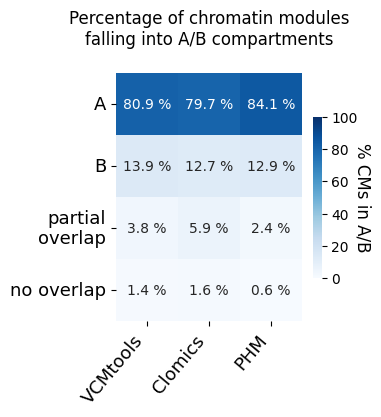

In [9]:
fig, ax0 = plt.subplots(1, 1, figsize=(3, 7))

ax = sns.heatmap(
    ab_comp_df * 100,
    cmap="Blues",
    annot=True,
    cbar=True,
    square=1,
    fmt=".1f",
    vmin=0,
    vmax=100,
    cbar_kws={"shrink": 0.3},
)
cbar_ax = fig.axes[-1]
cbar_ax.set_ylabel("% CMs in A/B", rotation=270, labelpad=10, size=12)
for t in ax.texts:
    t.set_text(t.get_text() + " %")
plt.xticks(size=13, rotation=50, ha="right")
plt.yticks(size=13, rotation=0)
plt.title("Percentage of chromatin modules\nfalling into A/B compartments\n")

plt.savefig(
    os.path.join(
        core_path,
        "plots",
        "percentage_of_" + dataset + "_CMs_in_AB_compartments_per_method.pdf",
    ),
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

Create Violin plots for CM lengths and sizes, where CMs are fully in TADs/AB compartments

In [10]:
dict_with_lengths_per_method = {}
dict_with_sizes_per_method = {}
for method in methods:
    tracks_df, content_df = utils.get_cm_tracks_content(
        core_cm_path,
        method,
        dataset,
        pp_threshold=pp_threshold,
        vcm_window=vcm_window,
        pv_threshold=pv_threshold,
        n_peaks=n_peaks,
        bg_threshold=bg_threshold,
    )
    cms_in_tads = pd.read_csv(
        os.path.join(
            core_path,
            "cm_overlaps",
            method,
            "_".join([dataset, "TADs", "cm_tracks_overlap.bed"]),
        ),
        sep="\t",
        header=None,
    )
    cms_in_abs = pd.read_csv(
        os.path.join(
            core_path,
            "cm_overlaps",
            method,
            "_".join([dataset, "AB", "cm_tracks_overlap.bed"]),
        ),
        sep="\t",
        header=None,
    )
    cms_fully_in_tads = cms_in_tads[
        cms_in_tads.iloc[:, -1] == cms_in_tads.iloc[:, 2] - cms_in_tads.iloc[:, 1]
    ]
    cms_fully_in_abs = cms_in_abs[
        cms_in_abs.iloc[:, -1] == cms_in_abs.iloc[:, 2] - cms_in_abs.iloc[:, 1]
    ]
    cms_fully_in_tads = cms_fully_in_tads[
        ~cms_fully_in_tads.iloc[:, 3].duplicated()
    ].copy()
    cms_fully_in_abs = cms_fully_in_abs[
        ~cms_fully_in_abs.iloc[:, 3].duplicated()
    ].copy()

    cms_in_tads_abs = set(cms_fully_in_abs.iloc[:, 3]).intersection(
        set(cms_fully_in_tads.iloc[:, 3])
    )

    cms_in_tads_abs_df = tracks_df[tracks_df.iloc[:, 3].isin(cms_in_tads_abs)].copy()
    cms_not_in_tads_abs_df = tracks_df[
        ~tracks_df.iloc[:, 3].isin(cms_in_tads_abs)
    ].copy()

    cms_in_A = cms_fully_in_abs[cms_fully_in_abs.iloc[:, -2].str.contains("A")]
    cms_in_B = cms_fully_in_abs[cms_fully_in_abs.iloc[:, -2].str.contains("B")]
    dict_with_lengths_per_method[method] = {
        "A": np.log10(np.array(cms_in_A.iloc[:, 2] - cms_in_A.iloc[:, 1])),
        "B": np.log10(np.array(cms_in_B.iloc[:, 2] - cms_in_B.iloc[:, 1])),
    }
    dict_with_sizes_per_method[method] = {
        "A": np.log2(np.array(cms_in_A.iloc[:, 9])),
        "B": np.log2(np.array(cms_in_B.iloc[:, 9])),
    }

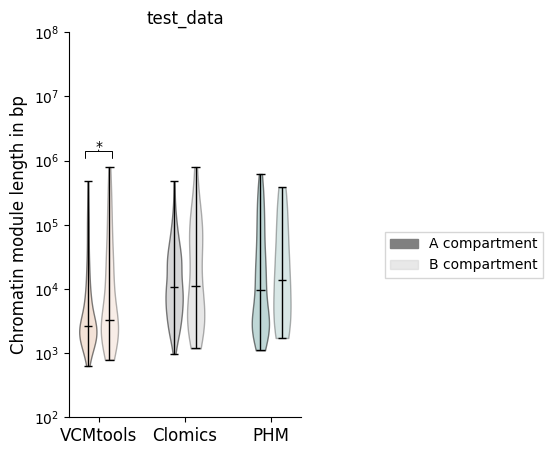

In [11]:
utils.boxplot_by_range(
    dict_with_lengths_per_method,
    "length",
    dataset,
    save_figure=True,
    path=os.path.join(core_path, "plots"),
    file_name="_".join(
        [dataset, "all_methods", "lengths" "wrt_AB_compartments_violin_plots.pdf"]
    ),
    stars_y_shift=0.2,
)

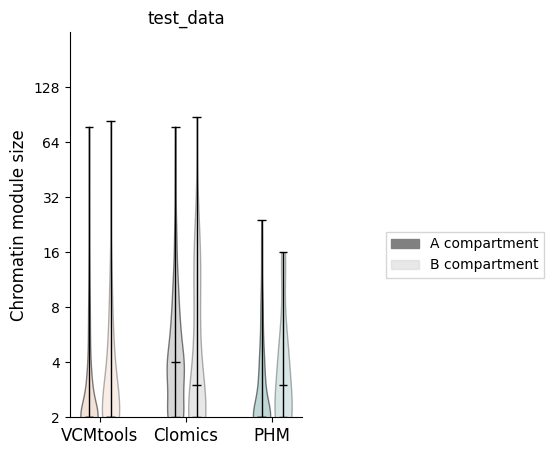

In [12]:
utils.boxplot_by_range(
    dict_with_sizes_per_method,
    "size",
    dataset,
    save_figure=True,
    path=os.path.join(core_path, "plots"),
    file_name="_".join(
        [dataset, "all_methods", "sizes" "wrt_AB_compartments_violin_plots.pdf"]
    ),
    stars_y_shift=0.2,
)

### Get peaks fully in TADs, A/B compartments

In [14]:
for region_type in ["AB", "TADs"]:
    for method in methods:
        cm_peaks = pd.read_csv(
            os.path.join(
                core_path,
                "peak_overlaps",
                method,
                "_".join([dataset, region_type, "cm_peaks_overlap.bed"]),
            ),
            sep="\t",
            header=None,
        )
        not_cm_peaks = pd.read_csv(
            os.path.join(
                core_path,
                "peak_overlaps",
                method,
                "_".join([dataset, region_type, "not_cm_peaks_overlap.bed"]),
            ),
            sep="\t",
            header=None,
        )
        cm_peaks_fully_in_region = cm_peaks.loc[
            cm_peaks.iloc[:, -1] == (cm_peaks.iloc[:, 2] - cm_peaks.iloc[:, 1]), :
        ]
        not_cm_peaks_fully_in_region = not_cm_peaks.loc[
            not_cm_peaks.iloc[:, -1]
            == (not_cm_peaks.iloc[:, 2] - not_cm_peaks.iloc[:, 1]),
            :,
        ]
        output_path = os.path.join(core_path, "peak_overlaps", method, "full_overlap")
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        cm_peaks_fully_in_region.to_csv(
            os.path.join(
                output_path,
                "_".join([dataset, region_type, "cm_peaks_full_overlap.bed"]),
            ),
            sep="\t",
            index=False,
            header=False,
        )
        not_cm_peaks_fully_in_region.to_csv(
            os.path.join(
                output_path,
                "_".join([dataset, region_type, "not_cm_peaks_full_overlap.bed"]),
            ),
            sep="\t",
            index=False,
            header=False,
        )